In [93]:
#Preliminaries
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
import math
from sklearn.utils import resample
from scipy import percentile
from scipy import stats
from matplotlib import pyplot as plt
import requests
import io
import seaborn as sns
from matplotlib.patches import Rectangle
sns.set()

## TODO
Replace all variable names with longer names that are easier to remember

### Load Data

In [2]:
# Dataset is local, not on github
Y_raw = pd.read_csv('../data/global_funds.csv',parse_dates=['Dates'],index_col=['Dates'])
X_raw = pd.read_csv('../data/global_factors.csv',parse_dates=['Dates'],index_col=['Dates'])
    
Y_raw.shape,X_raw.shape


((240, 193), (240, 4))

In [3]:
# Create lists of Fama-French factors and mutual fund symbols
min_number_of_obs = 120
Y_all = Y_raw.loc[:, (Y_raw.count().values > min_number_of_obs)] # discard funds with too many missing values
Y_all = Y_all.sub(X_raw['RF'],axis=0) # subtract RF from fund returns
funds = Y_all.columns.get_values().tolist() # list with names of funds
factors = X_raw.columns.get_values().tolist() # list with names of global factors

# remove RF since we already differenced it in Y
factors_remove = ['RF'] # remove these factors from list of factors
for items in factors_remove:
    factors.remove(items)

Y_all.shape, len(factors)

((240, 125), 3)

In [4]:
# create matrix of regressors for regression analysis
X_mat=X_raw[factors].copy()
X_mat.insert(0, 'const', float(1)) # insert column of ones for the constant in regression
X_mat.rename({'WLRF':'Mkt-RF'},axis='columns',inplace=True)
# Data Type and Shape information
X_mat.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 240 entries, 1999-01-31 to 2018-12-31
Data columns (total 4 columns):
const     240 non-null float64
Mkt-RF    240 non-null float64
SMB       240 non-null float64
HML       240 non-null float64
dtypes: float64(4)
memory usage: 9.4 KB


## 1. Constructing matrix of dependent variables (fund returns) and explanatory variables (factor returns)

In [5]:
# Parameters of Simulations
np.random.seed(2) 
n_obs = X_mat.shape[0]  # number of observations
n_funds = Y_all.shape[1]  # number of funds with return series
n_factors = X_mat.shape[1]-1 # risk factors
n_simulations = 1000 # number of simulations

# Variable Names
factor_names=['Alpha','Mkt-RF','SMB','HML']
sim_factors=['Mkt-RF', 'SMB', 'HML']
one_name=['Alpha']

# Empty coefficient and standard error matrices (fill with results later)
orig_coeffs = pd.DataFrame(np.zeros(shape = (n_factors+1, n_funds)), index=factor_names, columns = funds)/0
orig_SE_coeffs = pd.DataFrame(np.zeros(shape = (n_factors+1, n_funds)), index=factor_names, columns = funds)/0


## 2. Perform initial regressions on actual fund returns

In [6]:
#Create function to calculate the lag selection parameter for the standard HAC Newey-West
# (1994) plug-in procedure
def mLag(no_obs):
    result = math.floor(math.pow(4*no_obs/100,(2/9)))
    return result

#Set up regression function with Newey-West Standard Errors (HAC)
def ols(dependent_var, regressors, no_obs):
    result = sm.OLS(endog=dependent_var, exog=regressors, missing='drop').\
                fit(cov_type='HAC',cov_kwds={'maxlags':mLag(no_obs)+1})
    return result


In [7]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i = (~np.isnan(Y_all)).sum(axis=0) # number of observations of each fund in data

# Test ols function
test_fund = 0
y_sample = Y_all.iloc[:,test_fund]         # y_sample is just one column of Y_all
lm = ols(y_sample, X_mat, n_i.iloc[test_fund]) 

# Check Sample Regression Results
for name,result in zip(['coefficients','standard errors','# observations'],
                       [lm.params, lm.bse, lm.nobs]):
    print(name)
    print("-"*len(name))
    print(result,"\n")

coefficients
------------
const     0.154505
Mkt-RF    0.928434
SMB      -0.006721
HML       0.127987
dtype: float64 

standard errors
---------------
const     0.067194
Mkt-RF    0.016006
SMB       0.047993
HML       0.048858
dtype: float64 

# observations
--------------
240.0 



In [8]:
#Perform initial regressions on fund returns
for fund in range(n_funds):
    y_sample = Y_all.iloc[:,fund] # choose fund
    lm = ols(y_sample,X_mat, n_i[fund]) # run OLS
    
    for factor in range(n_factors+1):   
        orig_coeffs.iloc[factor, fund] = lm.params.iloc[factor]
        orig_SE_coeffs.iloc[factor, fund] = lm.bse.iloc[factor]

### TODO
Checkout a plotly representation of the coefficient and standard error data. Possibly four histograms.

In [9]:
# Regression coefficient dataframe preview
print(orig_coeffs.info())
orig_coeffs

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Alpha to HML
Columns: 125 entries, CWIAX to WIMVX
dtypes: float64(125)
memory usage: 3.9+ KB
None


CWIAX     CNPAX     TEDIX     VTWSX     OWLSX     TEPLX     OPPAX  \
Alpha   0.154505  0.218319  0.233386 -0.046309 -0.148419 -0.115127  0.180215   
Mkt-RF  0.928434  0.956883  0.635116  1.018592  0.940250  1.025993  1.076128   
SMB    -0.006721 -0.046306  0.063753 -0.082902  0.099940 -0.086029  0.259808   
HML     0.127987 -0.105683  0.178474 -0.013044  0.075871  0.412880 -0.129258   

           DODWX     DGEIX     VHGEX    ...        CGVIX     CAMAX     IGEIX  \
Alpha   0.032865 -0.004745  0.058377    ...    -0.058347  0.128421 -0.114825   
Mkt-RF  1.176468  1.041001  1.043070    ...     1.171983  1.327107  0.925567   
SMB    -0.038668  0.081525  0.073279    ...     0.016620  0.185925 -0.251603   
HML     0.387016  0.132983  0.318419    ...     0.266287  0.337161  0.310782   

           COGZX     BGVIX     ENTIX     GGESX     APGRX     TRGSX     WIMVX  
Alpha  -0.045402 -0.108252  0.168479 -0.140284 -0.058788  0.002218 -0.053521  
Mkt-RF  1.090783  0.939282  1.101993  1.041232  1.143330  1.211893  0.863205  
SMB     0.070205 -0.158022  0.262646 -0.114851  0.126472  0.057608 -0.254508  
HML    -0.504720  0.347489 -0.160079  0.223675 -0.231549 -0.495760  0.076776  

[4 rows x 125 columns]

In [10]:
# Coefficient Standard Error preview
orig_SE_coeffs.info()
orig_SE_coeffs

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, Alpha to HML
Columns: 125 entries, CWIAX to WIMVX
dtypes: float64(125)
memory usage: 3.9+ KB


CWIAX     CNPAX     TEDIX     VTWSX     OWLSX     TEPLX     OPPAX  \
Alpha   0.067194  0.064061  0.099452  0.036009  0.103827  0.080322  0.118825   
Mkt-RF  0.016006  0.016675  0.039595  0.011834  0.040671  0.021457  0.021452   
SMB     0.047993  0.037942  0.054646  0.031558  0.050922  0.043777  0.104469   
HML     0.048858  0.050323  0.058265  0.024102  0.042594  0.053396  0.106726   

           DODWX     DGEIX     VHGEX    ...        CGVIX     CAMAX     IGEIX  \
Alpha   0.106762  0.051201  0.068267    ...     0.124802  0.301439  0.069854   
Mkt-RF  0.035036  0.018400  0.019853    ...     0.046939  0.085222  0.020157   
SMB     0.064742  0.039028  0.054472    ...     0.115095  0.172982  0.042808   
HML     0.065702  0.043337  0.048886    ...     0.061932  0.184432  0.052187   

           COGZX     BGVIX     ENTIX     GGESX     APGRX     TRGSX     WIMVX  
Alpha   0.169693  0.074499  0.199775  0.074333  0.098411  0.137063  0.112118  
Mkt-RF  0.043701  0.026889  0.064333  0.023972  0.028400  0.060220  0.027327  
SMB     0.112873  0.067496  0.130762  0.048922  0.053159  0.101444  0.052525  
HML     0.090369  0.055219  0.116445  0.050436  0.043668  0.071610  0.056171  

[4 rows x 125 columns]

Added this chart, to help visualize alphas and standard errors

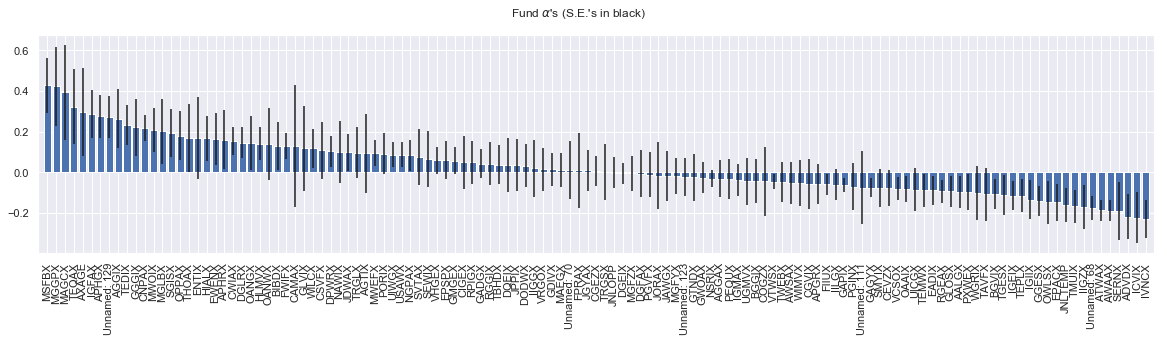

In [11]:
# sort by alpha (descending order)
funds_by_alpha = np.argsort(orig_coeffs.iloc[0,:])[::-1] 

# Bar Chart
plt.figure(figsize=(20,4))
plt.bar(x=range(n_funds),
        height=orig_coeffs.iloc[0,:][funds_by_alpha],
        tick_label=orig_coeffs.columns[funds_by_alpha],
        yerr=orig_SE_coeffs.iloc[0,:][funds_by_alpha])
plt.xticks(rotation=90)
plt.xlim((-1,n_funds))
plt.suptitle(r"Fund $\alpha$'s (S.E.'s in black)")

plt.show()

In [12]:
# rename all coefficients with t(.)
rename_dict = {}
for coeff in orig_coeffs.index:
    rename_dict[coeff] = 't({})'.format(coeff) 

# Calculate t-statistics with nans creating other nans (fill_value=None)
orig_t_stats = orig_coeffs.divide(orig_SE_coeffs, axis='columns', fill_value=None).rename(rename_dict,axis='index')
orig_t_stats

CWIAX      CNPAX      TEDIX      VTWSX      OWLSX      TEPLX  \
t(Alpha)    2.299372   3.407998   2.346720  -1.286024  -1.429483  -1.433317   
t(Mkt-RF)  58.006242  57.385411  16.040320  86.071662  23.118600  47.816327   
t(SMB)     -0.140036  -1.220435   1.166670  -2.626950   1.962605  -1.965159   
t(HML)      2.619575  -2.100086   3.063157  -0.541205   1.781287   7.732469   

               OPPAX      DODWX      DGEIX      VHGEX    ...          CGVIX  \
t(Alpha)    1.516646   0.307831  -0.092684   0.855138    ...      -0.467519   
t(Mkt-RF)  50.164448  33.579313  56.576723  52.540700    ...      24.968206   
t(SMB)      2.486946  -0.597266   2.088864   1.345255    ...       0.144403   
t(HML)     -1.211126   5.890446   3.068588   6.513494    ...       4.299664   

               CAMAX      IGEIX      COGZX      BGVIX      ENTIX      GGESX  \
t(Alpha)    0.426026  -1.643792  -0.267552  -1.453064   0.843345  -1.887231   
t(Mkt-RF)  15.572290  45.918663  24.960339  34.931681  17.129575  43.434728   
t(SMB)      1.074823  -5.877479   0.621983  -2.341202   2.008583  -2.347630   
t(HML)      1.828101   5.955161  -5.585127   6.292898  -1.374715   4.434818   

               APGRX      TRGSX      WIMVX  
t(Alpha)   -0.597369   0.016179  -0.477360  
t(Mkt-RF)  40.258584  20.124354  31.588523  
t(SMB)      2.379146   0.567885  -4.845417  
t(HML)     -5.302437  -6.923101   1.366821  

[4 rows x 125 columns]

In [13]:
# Calculated predictions, residuals, and sum of squared residuals (SSR) 
# and standard errors (SE )from X inputs and orig_coeffs
Y_pred = np.dot(X_mat.values,orig_coeffs.values) # fitted values
orig_resids = Y_all.values - Y_pred              # residuals
orig_SSR = np.nansum(orig_resids**2,0)           # sum squared residuals
orig_SE_resid = np.divide(orig_SSR**.5, (n_i-n_factors)) # standard errors

# 
print(orig_SE_resid.shape)
orig_SE_resid.head()

(125,)


CWIAX    0.063785
CNPAX    0.061459
TEDIX    0.086532
VTWSX    0.042760
OWLSX    0.089743
dtype: float64

In [14]:
# Rank funds by alpha
rank_a = orig_coeffs.transpose(copy=True)
rank_a['Rank_a'] = rank_a['Alpha'].rank(ascending=False)
orig_coeffs_rank_a = rank_a.sort_values(by='Alpha', axis=0, ascending=False)

# Print Previews
print("Ten Most Positive Alphas")
print(orig_coeffs_rank_a.head(10),"\n")
print("Ten Most Negative Alphas")
print(orig_coeffs_rank_a.tail(10))

Ten Most Positive Alphas
                 Alpha    Mkt-RF       SMB       HML  Rank_a
MSFBX         0.427591  0.714611 -0.266890  0.038603     1.0
MGGPX         0.423748  1.150749  0.302729 -0.573910     2.0
MAGCX         0.392557  1.039371  0.750257 -0.230193     3.0
TEQAX         0.321823  0.920811  0.251732 -0.751767     4.0
AXAGE         0.296094  1.239881  0.350411 -0.266739     5.0
IGFAX         0.287707  0.730322 -0.333441 -0.107715     6.0
APHGX         0.274649  0.868930 -0.247148  0.201847     7.0
Unnamed: 129  0.270221  1.001486  0.136358 -0.394302     8.0
AGGIX         0.263983  0.989996  0.200862 -0.345853     9.0
TEDIX         0.233386  0.635116  0.063753  0.178474    10.0 

Ten Most Negative Alphas
                Alpha    Mkt-RF       SMB       HML  Rank_a
JNLTEMP     -0.161314  1.020641 -0.153533  0.280705   116.0
TMUIX       -0.167947  1.091462  0.062179 -0.177965   117.0
IIGZX       -0.170155  1.025652 -0.343237  0.147015   118.0
Unnamed: 68 -0.174744  0.976101 -0.17

In [15]:
#Rank funds by t(alpha)
rank_t = orig_t_stats.transpose(copy=True)
rank_t['Rank_t'] = rank_t['t(Alpha)'].rank(ascending=False)
orig_coeffs_rank_t = rank_t.sort_values(by='t(Alpha)', axis=0, ascending=False)

# Print Previews
print("Ten Most Significant Positive Alphas")
print(orig_coeffs_rank_t.head(10),"\n")
print("Ten Most Significant Negative Alphas")
print(orig_coeffs_rank_t.tail(10))


Ten Most Significant Positive Alphas
              t(Alpha)  t(Mkt-RF)    t(SMB)    t(HML)  Rank_t
CNPAX         3.407998  57.385411 -1.220435 -2.100086     1.0
MSFBX         3.149317  18.404386 -2.043943  0.271595     2.0
Unnamed: 129  2.634869  46.619731  1.758379 -5.178336     3.0
APHGX         2.596955  31.674597 -3.150700  3.167546     4.0
IGFAX         2.417043  17.852991 -2.598018 -0.921890     5.0
TEDIX         2.346720  16.040320  1.166670  3.063157     6.0
CWIAX         2.299372  58.006242 -0.140036  2.619575     7.0
MGGPX         2.181862  28.819273  2.152420 -5.480641     8.0
FWIFX         2.055572  53.997903  1.129708 -1.682369     9.0
MWOIX         1.948472  43.720206  1.149368 -3.659001    10.0 

Ten Most Significant Negative Alphas
             t(Alpha)  t(Mkt-RF)    t(SMB)    t(HML)  Rank_t
GAPIX       -1.727903  89.597109  1.349512  4.732440   116.0
ICVIX       -1.771677  18.645418  2.614154  7.407417   117.0
GGESX       -1.887231  43.434728 -2.347630  4.434818   118.

## 3. Constructing series of simulated returns

In [16]:
# Construct simulated series based on "sim_indices"
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# * h = total number of factors
# * m = total number of time periods
# * s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha



try: annual_std_alpha
except NameError: annual_std_alpha = None

if annual_std_alpha is None:
    annual_std_alpha = 0 #Set it's value
else:
    pass
std_alpha = annual_std_alpha/np.sqrt(12)  
annual_std_alpha, std_alpha
  

(0, 0.0)

In [17]:
temp_std_resid_ratio = np.divide(orig_SE_resid,orig_SE_resid.mean())
temp_std_resid_ratio.head()

CWIAX    0.620337
CNPAX    0.597716
TEDIX    0.841560
VTWSX    0.415856
OWLSX    0.872787
dtype: float64

In [18]:
# Construct series of alphas for injection (constant over time, scaled per
# fund, independent per simulation). These numbers become zero when we set
# desired injection of average annual alpha to zero above.
# np.random.seed(0)
temp_alpha = std_alpha * np.tile(np.random.randn(1,n_funds,n_simulations) * 
                                 np.tile(temp_std_resid_ratio,(1,1,n_simulations))\
                                 .reshape((1,n_funds,n_simulations), order='F'),(n_obs,1,1))
# A collection of 1000 individual 240 by 125 arrays
temp_alpha.shape


(240, 125, 1000)

In [28]:
# Construct matrix of betas from coefficient matrix (excluding alphas)
orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
orig_betas.shape, temp_alpha.shape

((3, 125), (240, 125, 1000))

## TODO
Consider changing variable names to something cleaner

In [29]:
# Construct matrices of all simulated factor and fund returns:
constructed_X_mat = np.empty((n_obs,n_factors,n_simulations))*np.nan # X_mats for each simulation
constructed_resids = np.empty((n_obs,n_funds,n_simulations))*np.nan  # resids for each simulation
constructed_Y_all = np.empty((n_obs,n_funds,n_simulations))*np.nan   # n_funds fund returns for each sim
sim_indices = np.random.randint(0, n_obs, size=(n_obs,n_simulations))    # randomized simulations

# run simulations and fill matrices
for simulation in range(n_simulations):
    # randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
    constructed_X_mat[:,:,simulation] = X_mat.values[:,1:4][sim_indices[:,simulation],:] 
    
    # randomized simulations of residuals from Fama-French equations
    constructed_resids[:,:,simulation] = orig_resids[sim_indices[:,simulation],:]  
    
    #simulated returns based on fund betas, randomized resids and alphas (0?)
    constructed_Y_all[:,:,simulation] = temp_alpha[:,:,simulation] + \
                                        np.matmul(constructed_X_mat[:,:,simulation], orig_betas) + \
                                        constructed_resids[:,:,simulation] 
# Check shapes
constructed_X_mat.shape, constructed_resids.shape, constructed_Y_all.shape


((240, 3, 1000), (240, 125, 1000), (240, 125, 1000))

## 4. Performing regressions on simulated series

In [30]:
# Script that does bootstrap regression results for all funds.

# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
sim_cutoff = 15

# Populate target output vectors to be filled in with loop:
sim_coeffs = np.empty((n_factors+1,n_funds,n_simulations))*np.nan
sim_SE_coeffs = np.empty((n_factors+1,n_funds,n_simulations))*np.nan

#sim_coeffs.shape, sim_coeffs
sim_coeffs.shape, sim_coeffs[:,1,1]

((4, 125, 1000), array([nan, nan, nan, nan]))

In [31]:
# Calculate number of observations per fund per simulation for future
# reference:
n_i_s = (~np.isnan(constructed_Y_all)).sum(0)
n_i_s.shape, n_i_s[0,99]

((125, 1000), 240)

In [32]:
# Calculate the lag selection parameter for the standard Newey-West HAC
# estimate (Andrews and Monohan, 1992), one number per fund per simulation:
maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
maxLag_s.shape, type(maxLag_s[1,1])

((125, 1000), numpy.int64)

In [33]:
# Set up regression function with Newey-West Standard Errors (HAC)
def ols_s(left_side, right_side, maxLag_temp):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':maxLag_temp})
    return result

In [34]:
xa = sm.add_constant(constructed_X_mat[:,:,0])
ya_sample = constructed_Y_all[:,0,0]
lma = ols_s(ya_sample, xa,2)
print(lma.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.913
Method:                 Least Squares   F-statistic:                     550.6
Date:                Mon, 25 Feb 2019   Prob (F-statistic):          3.16e-106
Time:                        14:05:51   Log-Likelihood:                -324.42
No. Observations:                 240   AIC:                             656.8
Df Residuals:                     236   BIC:                             670.8
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0464      0.064     -0.724      0.4

This one takes a bit. 1000 simulations * 125 funds = 125,000 regressions to run

In [35]:
# Loop through each simulation run:
for sim in range(n_simulations):
    
    #Loop through each fund:
    for fund in range(n_funds):
        
        if n_i_s[fund,sim]>= sim_cutoff:
            
            xa = sm.add_constant(constructed_X_mat[:,:,sim])
            ya_sample = constructed_Y_all[:,fund,sim]
            maxLag_temp = maxLag_s[fund,sim]

            # linear regression
            lma = ols_s(ya_sample, xa, maxLag_temp)
            sim_SE_coeffs[:,fund,sim] = lma.bse
            sim_coeffs[:,fund,sim] = lma.params

sim_t_stats = np.divide(sim_coeffs,sim_SE_coeffs)
sim_t_stats.shape, sim_coeffs.shape, sim_SE_coeffs.shape

((4, 125, 1000), (4, 125, 1000), (4, 125, 1000))

## 5. Estimating/constructing the bootstrapping results/tables

In [36]:
# This script calculates the averages of alphas/t-stat in different
# ranks/percentiles of the simulation runs. Additionally, it estimates the
# percent of simulated alphas/t-stats of each rank/percentile, that are
# lower than the 'actual' (historically observed) alpha/t-stat at the same
# rank/percentile.

# NOTE: With 100 funds to calculate percentiles from, for the low and high
# percentiles, we rather use the value of funds with rank #1-5 and 97-101.
# For the 'middle' percentiles, we use matlab's 'prctile(___)'-function
# which interpolates linearly between observations.

# Construct matrix of relevant percentages (10 through 90);
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
percentages, type(percentages)

([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], list)

In [61]:
# Sort original alphas and t-values in order to extract top/bottom ranked values:
temp_sorted_orig_a = orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0]).T
temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(Alpha)'], axis=1, ascending = [0]).T
temp_sorted_orig_a.shape, temp_sorted_orig_t.shape 

((125, 1), (125, 1))

In [65]:
percentiles_orig_a = [temp_sorted_orig_a.tail(5).iloc[::-1], \
                       temp_sorted_orig_a.quantile(percentages),\
                       temp_sorted_orig_a.head(5).iloc[::-1]]
percentiles_orig_a

[          Alpha
 IVNCX -0.229878
 ICVIX -0.222565
 ADVDX -0.219048
 SERNX -0.190659
 AWAAX -0.188634,         Alpha
 0.1 -0.138338
 0.2 -0.089291
 0.3 -0.058700
 0.4 -0.028486
 0.5  0.008053
 0.6  0.042440
 0.7  0.093222
 0.8  0.140291
 0.9  0.205200,           Alpha
 AXAGE  0.296094
 TEQAX  0.321823
 MAGCX  0.392557
 MGGPX  0.423748
 MSFBX  0.427591]

In [66]:
# temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
temp1t = temp_sorted_orig_t.tail(5)[::-1]
temp2t = temp_sorted_orig_t.quantile(percentages)
temp3t = temp_sorted_orig_t.head(5)[::-1]
percentiles_orig_t = [temp1t, temp2t, temp3t]
percentiles_orig_t

[             t(Alpha)
 AWAAX       -3.787495
 ATWAX       -3.702615
 Unnamed: 68 -2.998788
 IVNCX       -2.432716
 TMUIX       -2.070504,      t(Alpha)
 0.1 -1.634098
 0.2 -1.227415
 0.3 -0.609360
 0.4 -0.300439
 0.5  0.053437
 0.6  0.398654
 0.7  0.784608
 0.8  1.261662
 0.9  1.754968,               t(Alpha)
 IGFAX         2.417043
 APHGX         2.596955
 Unnamed: 129  2.634869
 MSFBX         3.149317
 CNPAX         3.407998]

In [72]:
# Find averages of simulated ranks/percentiles for alphas and t-values:
# NOTE: For each simulation run, we find the percentiles corresponding to the
# percentages above and the top/bottom 5 ranked values. For each
# rank/percentile, we then take the average of the alphas/t-stats over
# all simulation runs with ('prctile'-formula treats 'NaN' values as
# missing and removes them, so this is not a problem). Some simulation runs
# may have less than 101 valid regressions (due to some funds with short
# original series and our required number of observations for a regression
# to be valid).

# Ascending sort of simulated alphas per simulation:
temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].T, axis=1)
temp_sort_asc_sim_a.shape

(1000, 125)

In [78]:
# Ascending sort of simulated t-stats per simulation:
temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].T, axis=1)
temp_sort_asc_sim_t.shape

array([[-1.79316545, -1.69290828, -1.59162139, ...,  2.24899993,
         2.38420711,  2.51822493],
       [-3.63168598, -2.18734921, -2.0140462 , ...,  2.17030427,
         2.42582529,  2.5936539 ],
       [-2.29046067, -2.28028817, -2.08713744, ...,  1.32490902,
         1.62754608,  2.20835531],
       ...,
       [-1.95556073, -1.93109152, -1.77449457, ...,  2.25573219,
         2.64616553,  3.21618574],
       [-2.34290737, -2.24887111, -2.19476335, ...,  1.98233057,
         2.40743559,  2.60126735],
       [-2.75552502, -2.5020493 , -2.38649784, ...,  0.95799275,
         1.43305076,  2.07038192]])

In [92]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of alpha each simulation (result is a 21 x 10000 matrix):


percentages1 = [10,20,30,40,50,60,70,80,90]
temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.T[0:5,:],\
                                         np.percentile(sim_coeffs[0,:,:].T,\
                                                       percentages1, axis = 1),\
                                         temp_sort_asc_sim_a.T[-5:,:]))
temp_percentiles_sim_a, percentiles_orig_a

(array([[-0.29813672, -0.35368995, -0.31830288, ..., -0.26891435,
         -0.35682621, -0.35156936],
        [-0.24137571, -0.3206212 , -0.30995228, ..., -0.22189064,
         -0.25197245, -0.29129034],
        [-0.16690615, -0.24536416, -0.30668417, ..., -0.19325408,
         -0.23989391, -0.2759839 ],
        ...,
        [ 0.21309655,  0.24739306,  0.16545962, ...,  0.21267976,
          0.31995381,  0.10771364],
        [ 0.21723759,  0.26604   ,  0.18775489, ...,  0.25380626,
          0.40186805,  0.11251564],
        [ 0.21869494,  0.53035404,  0.20595085, ...,  0.38758604,
          0.40615972,  0.15950765]]), [          Alpha
  IVNCX -0.229878
  ICVIX -0.222565
  ADVDX -0.219048
  SERNX -0.190659
  AWAAX -0.188634,         Alpha
  0.1 -0.138338
  0.2 -0.089291
  0.3 -0.058700
  0.4 -0.028486
  0.5  0.008053
  0.6  0.042440
  0.7  0.093222
  0.8  0.140291
  0.9  0.205200,           Alpha
  AXAGE  0.296094
  TEQAX  0.321823
  MAGCX  0.392557
  MGGPX  0.423748
  MSFBX  0.427591]

In [90]:
# Construct matrix containing the top/bottom 5 ranks and 9 different
# percentiles of t-stat in each simulation (result is a 21 x 10000 matrix):

temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.T[0:5,:],\
                                         np.percentile(sim_t_stats[0,:,:].T, percentages1, axis = 1),\
                                         temp_sort_asc_sim_t.T[-5:,:]))
temp_percentiles_sim_t.shape

(19, 1000)

In [0]:
#Take the means across each rank/percentile:

mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1)
mean_percentiles_sim_a, mean_percentiles_sim_t


(array([-0.33796649, -0.26894227, -0.23703043, -0.21516882, -0.1994744 ,
        -0.12804595, -0.07967369, -0.0492462 , -0.02474648, -0.00239923,
         0.02022153,  0.04476189,  0.07586237,  0.12392345,  0.19501151,
         0.2115141 ,  0.23301709,  0.26665145,  0.33693437]),
 array([-2.67552481, -2.31051443, -2.10383401, -1.96740323, -1.85528888,
        -1.30913516, -0.86687035, -0.55098646, -0.28106194, -0.02994312,
         0.22725451,  0.49351517,  0.80636352,  1.23846299,  1.76473903,
         1.87164569,  2.00828623,  2.2062045 ,  2.52989765]))

In [0]:
# Calculate the percentage of simulated alphas in each rank/percentile that % are smaller than actual alpha (and same for t-values):  
# sim_smaller_a = ...     
#   sum(temp_percentiles_sim_a < repmat(percentiles_orig_a,1,s),2) /s*100; 
#   sim_smaller_t = ...     sum(temp_percentiles_sim_t < repmat(percentiles_orig_t,1,s),2) /s*100; 

sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
sim_smaller_a, sim_smaller_t


(array([87.9, 72.8, 58.5, 65.8, 56.6, 37.5, 38. , 36.2, 42.8, 64.3, 80.1,
        95.4, 97.6, 98.3, 96.5, 96.2, 98.2, 96.4, 81.5]),
 array([ 5.5,  1.1,  4.3, 13.3, 29.7, 17.3, 14.3, 42.8, 46.2, 60.1, 70.8,
        82.5, 91.5, 93.3, 93.7, 94.5, 91.1, 96.1, 93.3]))

In [0]:
# Combine the above in one table (one for alpha and one for t-stat): 
table_a1=pd.DataFrame(data=np.vstack(percentiles_orig_a))
table_a2=pd.DataFrame(data=mean_percentiles_sim_a)
table_a3=pd.DataFrame(data=sim_smaller_a)
table_a4=pd.concat([table_a1, table_a2, table_a3], axis=1)
table_a4.columns=['Actual','Sim Avg', '%<Act']
idx = ['Worst','2nd','3rd','4th','5th','10%','20%','30%','40%','50%',
       '60%','70%','80%','90%','5th','4th','3rd','2nd','Best']
se=pd.Series(idx)
table_a4['Rank/pctl']=se.values
table_a = table_a4.set_index('Rank/pctl')
table_a

Actual   Sim Avg  %<Act
Rank/pctl                           
Worst     -0.229878 -0.337966   87.9
2nd       -0.222565 -0.268942   72.8
3rd       -0.219048 -0.237030   58.5
4th       -0.190659 -0.215169   65.8
5th       -0.188634 -0.199474   56.6
10%       -0.138338 -0.128046   37.5
20%       -0.089291 -0.079674   38.0
30%       -0.058700 -0.049246   36.2
40%       -0.028486 -0.024746   42.8
50%        0.008053 -0.002399   64.3
60%        0.042440  0.020222   80.1
70%        0.093222  0.044762   95.4
80%        0.140291  0.075862   97.6
90%        0.205200  0.123923   98.3
5th        0.296094  0.195012   96.5
4th        0.321823  0.211514   96.2
3rd        0.392557  0.233017   98.2
2nd        0.423748  0.266651   96.4
Best       0.427591  0.336934   81.5

In [0]:
# % Combine the above in one table (one for alpha and one for t-stat): 
table_t1=pd.DataFrame(data=np.vstack(percentiles_orig_t))
table_t2=pd.DataFrame(data=mean_percentiles_sim_t)
table_t3=pd.DataFrame(data=sim_smaller_t)
table_t4=pd.concat([table_t1, table_t2, table_t3], axis=1)
table_t4.columns=['Actual','Sim Avg', '%<Act']
setn=pd.Series(idx)
table_t4['Rank/pctl']=setn.values
table_t = table_t4.set_index('Rank/pctl')
table_t

Actual   Sim Avg  %<Act
Rank/pctl                           
Worst     -3.787495 -2.675525    5.5
2nd       -3.702615 -2.310514    1.1
3rd       -2.998788 -2.103834    4.3
4th       -2.432716 -1.967403   13.3
5th       -2.070504 -1.855289   29.7
10%       -1.634098 -1.309135   17.3
20%       -1.227415 -0.866870   14.3
30%       -0.609360 -0.550986   42.8
40%       -0.300439 -0.281062   46.2
50%        0.053437 -0.029943   60.1
60%        0.398654  0.227255   70.8
70%        0.784608  0.493515   82.5
80%        1.261662  0.806364   91.5
90%        1.754968  1.238463   93.3
5th        2.417043  1.764739   93.7
4th        2.596955  1.871646   94.5
3rd        2.634869  2.008286   91.1
2nd        3.149317  2.206205   96.1
Best       3.407998  2.529898   93.3

## 6. Generating CDF Plots

In [0]:
# Generate CDF plot for alphas: 
prct=np.arange(1,100,1)
smpl1=orig_coeffs.transpose()['Alpha']
smpl2=sim_coeffs[0,:,:].flatten()
smpl3=orig_t_stats.transpose()['t(alpha)']
smpl4=sim_t_stats[0,:,:].flatten()
smpl5=np.nanmean(np.percentile(sim_coeffs[0,:,:], prct, axis=0), axis=1)
smpl6=np.nanmean(np.percentile(sim_t_stats[0,:,:], prct, axis=0), axis=1)

def ecdf(sample):
    sample = np.atleast_1d(sample)
    quantiles, counts = np.unique(sample, return_counts=True)
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob



In [0]:
sim_t_stats

array([[[ 6.61838194e-02, -2.06780910e+00, -9.88427297e-01, ...,
         -6.05513507e-01,  8.17944909e-01,  9.98284884e-01],
        [ 1.38433875e+00, -2.22902914e+00, -4.49476880e-01, ...,
         -1.87220030e-01,  1.16288331e+00, -3.36962304e-01],
        [-2.66479425e+00,  6.63475084e-01,  3.42035967e-02, ...,
          9.50577951e-01, -1.25286289e+00, -8.54263835e-01],
        ...,
        [ 3.59853106e-01, -4.10092890e-01, -1.46030287e+00, ...,
          1.90110964e+00,  1.66832473e+00, -8.54460669e-01],
        [ 7.70485403e-01, -3.45880505e-01, -5.45656985e-02, ...,
          1.63791715e+00,  1.71688824e+00,  5.86918935e-01],
        [ 1.41168438e+00, -5.40041141e-01, -3.82764188e-01, ...,
         -4.71491388e-01, -1.62903988e-01,  2.37920435e-01]],

       [[ 7.42233851e+01,  5.78701455e+01,  6.22505275e+01, ...,
          7.12369166e+01,  5.87249917e+01,  4.92597213e+01],
        [ 5.51147404e+01,  6.01584569e+01,  6.78101179e+01, ...,
          4.73296611e+01,  4.07226065e

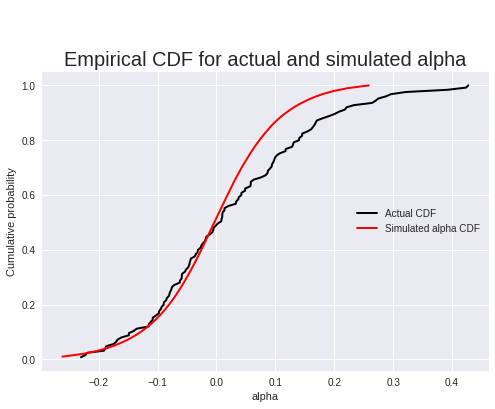

In [0]:
#Generate CDF plot for alphas: 

# compute the ECDF of the samples
qe, pe = ecdf(smpl5)
q, p = ecdf(smpl1)

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(q, p, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated alpha CDF')
ax.set_xlabel('alpha')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated alpha', fontsize=20)
plt.show()

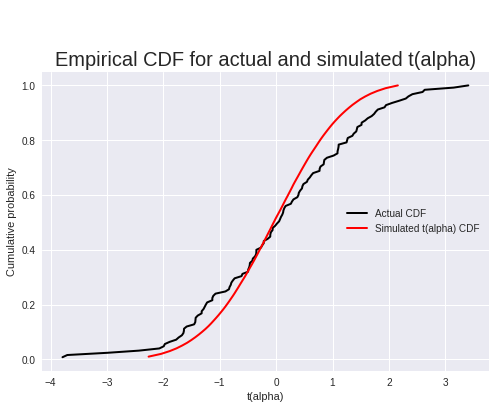

In [0]:
# Generate CDF plot for t(alphas): 
# compute the ECDF of the samples
qe, pe = ecdf(smpl6)
qt, pt = ecdf(smpl3)

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(qt, pt, '-k', lw=2, label='Actual CDF')
ax.plot(qe, pe, '-r', lw=2, label='Simulated t(alpha) CDF')
ax.set_xlabel('t(alpha)')
ax.set_ylabel('Cumulative probability')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nEmpirical CDF for actual and simulated t(alpha)', fontsize=20)
plt.show()

Text(0.5, 1.0, '\n\nDistribution of t(alpha) simulations')

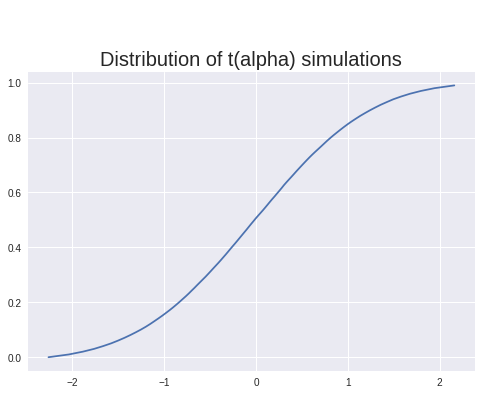

In [0]:
plt.plot(np.sort(smpl6), np.linspace(0, 1, len(smpl6), endpoint=False))
plt.title('\n\nDistribution of t(alpha) simulations', fontsize=20)
plt.show()

## 7. Generating Kernel smoothing density estimate plots

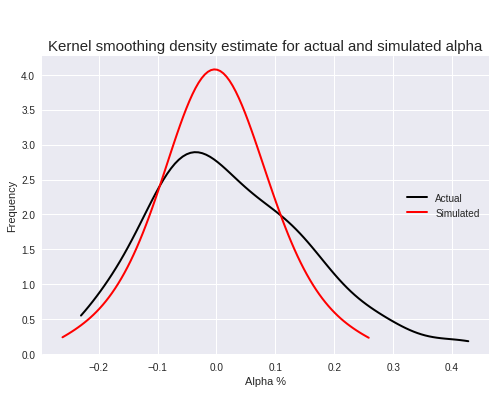

In [0]:
#   Generate Kernel smoothing density estimate plot for alphas: 

kde1 = stats.gaussian_kde(smpl1)
kde2 = stats.gaussian_kde(smpl5)
x1 = np.linspace(smpl1.min(), smpl1.max(), 100)
x2 = np.linspace(smpl5.min(), smpl5.max(), 100)
p1 = kde1(x1)
p2 = kde2(x2)

fig, ax = plt.subplots(1, 1)
ax.plot(x1, p1, '-k', lw=2, label='Actual')
ax.plot(x2, p2, '-r', lw=2, label='Simulated')
ax.set_xlabel('Alpha %')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated alpha', fontsize=15)
plt.show()

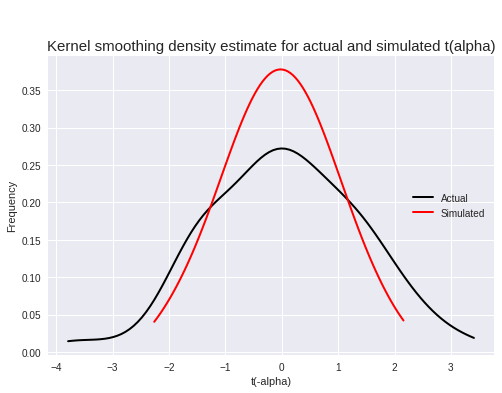

In [0]:
# Generate Kernel smoothing density estimate plot for t-stats of alpha
kde3 = stats.gaussian_kde(smpl3)
kde4 = stats.gaussian_kde(smpl6)
x3 = np.linspace(smpl3.min(), smpl3.max(), 100)
x4 = np.linspace(smpl6.min(), smpl6.max(), 100)
p3 = kde3(x3)
p4 = kde4(x4)

# plot
fig, ax = plt.subplots(1, 1)
ax.plot(x3, p3, '-k', lw=2, label='Actual')
ax.plot(x4, p4, '-r', lw=2, label='Simulated')
ax.set_xlabel('t(-alpha)')
ax.set_ylabel('Frequency')
ax.legend(fancybox=True, loc='right')
plt.title('\n\nKernel smoothing density estimate for actual and simulated t(alpha)', fontsize=15)
plt.show()

## 8. Generating histograms

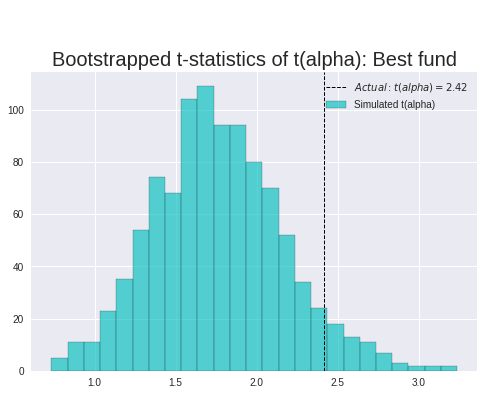

In [0]:
temp_input = 14
temp_t = np.vstack(percentiles_orig_t)[temp_input]
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])], bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Best fund', fontsize=20)
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)
plt.show()


In [0]:
temp_input = 0
temp_t = np.vstack(percentiles_orig_t)[temp_input]
result = plt.hist(temp_percentiles_sim_t[temp_input,:][~np.isnan(temp_percentiles_sim_t[temp_input,:])], bins=25, color='c', edgecolor='k', alpha=0.65)
plt.axvline(np.vstack(percentiles_orig_t)[temp_input], color='k', linestyle='dashed', linewidth=1)
plt.title('\n\nBootstrapped t-statistics of t(alpha): Worst fund', fontsize=20)
labels= ['$Actual: t(alpha) = {0:.2f}$'.format(float(temp_t)), 'Simulated t(alpha)']
plt.legend(labels)
plt.show()


In [0]:
#Generate histogram of simulated t(alpha)'s for various ranks/percentiles:
#Includes vertical line representing the actual performance of fund at
#equivalent rank/percentile:
#Different index INPUTS used to make histograms from
#'temp_percentiles_sim_t' and vertical lines from 'percentiles_orig_t'
#represent different ranks/percentiles to extract, as specified below:
#input: 1:5 - represents ranks: 101(worst):-1:97
#input: 6:14 - represents percentiles 10:10:90
#input: 15:19 - represents ranks 5:-1:1(best))

#BEST FUND

## 9. Loop through simulation program to inject alpha with different standard deviation assumptions

In [0]:
# Construct simulated series based on "sim_indices"
# tic; % Begin timer
# This script used the simulated index numbers to:
# 1) Pick corresponding numbers from factors and residuals, and
# 2) Construct series of fund returns (potentially including injected alpha)
# 3) Series are "alpha free" if 'std_alpha' below is set to '0'.

# The constructed returns will be the basis for new regressions to
# calculate simulated alphas.

# From before: n = total number of funds
# % h = total number of factors
# % m = total number of time periods
# % s = total number of simulations, s = 1 here refers sim #1

# Check if the value for annual "average" standard deviation is already
# defined. If it is, dont't touch it. If it isn't, define a chosen
# value (usually '0') below. We do this to avoid overriding the std of alpha
# in the loop running through different values of std of alpha

for std in [std/4 for std in range(0,15)]:
    try: annual_std_alpha
    except NameError: annual_std_alpha = None

    if annual_std_alpha is None:
        annual_std_alpha = 0 #Set it's value
    else:
        pass
    annual_std_alpha = std
    std_alpha = annual_std_alpha/np.sqrt(12)  
    annual_std_alpha, std_alpha
    temp_avg_orig_std_resid = np.nanmean(orig_SE_resid.values)
    temp_std_resid_ratio = np.divide(orig_SE_resid,temp_avg_orig_std_resid)
    adj_n = Y_all.shape[1]
    temp_alpha = std_alpha*np.tile(np.random.randn(1,adj_n,s) * np.tile(temp_std_resid_ratio,(1,1,s)).reshape((1,adj_n,s), order='F'),(m,1,1))
    orig_betas = orig_coeffs_rank_a.transpose().values[1:4,:]
    constructed_resids = np.empty((m,adj_n,s))*np.nan
    constructed_Y_all = np.empty((m,adj_n,s))*np.nan
    for ss in range(s):
        constructed_X_mat[:,:,ss] = X_mat.values[:,1:4][sim_indices[:,ss],:]  #randomized simulations of Fama-French risk factors: Mkt-RF, SMB, HML
        constructed_resids[:,:,ss] = orig_resids[sim_indices[:,ss],:]  #randomized simulations of residuals from Fama-French equations
        constructed_Y_all[:,:,ss] = temp_alpha[:,:,ss] + np.matmul(constructed_X_mat[:,:,ss], orig_betas) + constructed_resids[:,:,ss] #simulated returns based on fund betas, randomized resids and alphas (0?)

#S cript that does bootstrap regression results for all funds.

# Set minumum number of observations(n) required in simulation for the
# regression to be valid:
sim_cutoff = 15
# Populate target output vectors to be filled in with loop:
sim_SE_resid = np.empty((h+1,adj_n,s))*np.nan
sim_coeffs = np.empty((h+1,adj_n,s))*np.nan
# Calculate number of observations per fund per simulation for future
# reference:
n_i_s = (~np.isnan(constructed_Y_all)).sum(0)
# Calculate the lag selection parameter for the standard Newey-West HAC
# estimate (Andrews and Monohan, 1992), one number per fund per simulation:
maxLag_s = np.floor((4*(n_i_s/100)**(2/9))).astype(int)
#Set up regression function with Newey-West Standard Errors (HAC)
def ols_s(left_side, right_side, maxLag_temp):
    result = sm.OLS(left_side, right_side, missing='drop').fit(cov_type='HAC',cov_kwds={'maxlags':maxLag_temp})
    return result
#   xa = sm.add_constant(constructed_X_mat[:,:,0])
#   ya_sample = constructed_Y_all[:,0,0]
#   lma = ols_s(ya_sample, xa,2)
  # Loop through each simulation run:
for ss in range(s):
    #Loop through each fund:
    for jj in range(adj_n):
        if n_i_s[jj,ss]>= sim_cutoff:
            xa = sm.add_constant(constructed_X_mat[:,:,ss])
            ya_sample = constructed_Y_all[:,jj,ss]
            maxLag_temp = maxLag_s[jj,ss]

            # linear regression
            lma = ols_s(ya_sample, xa, maxLag_temp)
            sim_SE_resid[:,jj,ss] = .300
            sim_SE_resid[:,jj,ss] = lma.bse
            sim_coeffs[:,jj,ss] = lma.params
            
sim_t_stats = np.divide(sim_coeffs,sim_SE_resid)
percentages = [.10, .20, .30, .40, .50, .60, .70, .80, .90]
#Sort original alphas and t-values in order to extract top/bottom ranked values:
temp_sorted_orig_a =  orig_coeffs.take([0], axis=0).sort_values(by=['Alpha'], axis=1, ascending = [0])
temp_sorted_orig_t = orig_t_stats.take([0], axis=0).sort_values(by=['t(alpha)'], axis=1, ascending = [0])
temp_sorted_orig_a, temp_sorted_orig_t, type(temp_sorted_orig_t)
percentiles_orig_at = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1], \
                       temp_sorted_orig_a.transpose().quantile(percentages),\
                       temp_sorted_orig_a.transpose().head(5).iloc[::-1]]

temp1t = temp_sorted_orig_t.transpose().tail(5)
temp2t = temp_sorted_orig_t.transpose().quantile(percentages)
temp3t = temp_sorted_orig_t.transpose().head(5)
percentiles_orig_t = [temp1t, temp2t, temp3t]
percentiles_orig_a = np.empty(2, dtype=float)
percentiles_orig_a = [temp_sorted_orig_a.transpose().tail(5).iloc[::-1],temp_sorted_orig_a.transpose().quantile(percentages),temp_sorted_orig_a.transpose().head(5).iloc[::-1]]
percentiles_orig_t = np.empty(2, dtype=float)
percentiles_orig_t = [temp_sorted_orig_t.transpose().tail(5).iloc[::-1], temp_sorted_orig_t.transpose().quantile(percentages),temp_sorted_orig_t.transpose().head(5).iloc[::-1]]
temp_sort_desc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)[:,::-1]
temp_sort_asc_sim_a = np.sort(sim_coeffs[0,:,:].transpose(), axis=1)
temp_sort_desc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)[:,::-1]
temp_sort_asc_sim_t = np.sort(sim_t_stats[0,:,:].transpose(), axis=1)
percentages1 = [10,20,30,40,50,60,70,80,90]
#   np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1).shape
temp_percentiles_sim_a = np.concatenate((temp_sort_asc_sim_a.transpose()[0:5,:], \
                         np.percentile(sim_coeffs[0,:,:].transpose(), percentages1, axis = 1), \
                         temp_sort_desc_sim_a.transpose()[0:5,:][::-1]))
temp_percentiles_sim_t = np.concatenate((temp_sort_asc_sim_t.transpose()[0:5,:], \
                         np.percentile(sim_t_stats[0,:,:].transpose(), percentages1, axis = 1), \
                         temp_sort_desc_sim_t.transpose()[0:5,:][::-1]))
mean_percentiles_sim_a = np.nanmean(temp_percentiles_sim_a, axis=1)
mean_percentiles_sim_t = np.nanmean(temp_percentiles_sim_t, axis=1
sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
# sim_smaller_a = np.sum(temp_percentiles_sim_a < np.tile(np.vstack(percentiles_orig_a),(1,s)), axis=1)/s*100
# sim_smaller_t = np.sum(temp_percentiles_sim_t < np.tile(np.vstack(percentiles_orig_t),(1,s)), axis=1)/s*100
table_a1=pd.DataFrame(data=np.vstack(percentiles_orig_a))
table_a2=pd.DataFrame(data=mean_percentiles_sim_a)
table_a3=pd.DataFrame(data=sim_smaller_a)
table_a4=pd.concat([table_a1, table_a2, table_a3], axis=1)
table_a4.columns=['Actual','Sim Avg', '%<Act']
idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
se=pd.Series(idx)
table_a4['Rank/pctl']=se.values
table_a = table_a4.set_index('Rank/pctl')
table_t1=pd.DataFrame(data=np.vstack(percentiles_orig_t))
table_t2=pd.DataFrame(data=mean_percentiles_sim_t)
table_t3=pd.DataFrame(data=sim_smaller_t)    
table_t4=pd.concat([table_t1, table_t2, table_t3], axis=1)
table_t4.columns=['Actual','Sim Avg', '%<Act']
#     idx=['Worst',	'2nd',	'3rd',	'10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'3rd',	'2nd',	'Best']
set=pd.Series(idx)
table_t4['Rank/pctl']=set.values
table_t = table_t4.set_index('Rank/pctl')
t_index = [std/4 for std in range(0,15)]
data = pd.DataFrame([], index=idx, columns=t_index)
#     if std=0:
data.loc[:,std]=table_t['Sim Avg']
                                        
                                        
                                        
# Clear 'excess' variables no longer needed: 
del percentages
del temp_sort_desc_sim_a 
del temp_sort_asc_sim_a
del temp_sort_desc_sim_t 
del temp_sort_asc_sim_t
del mean_percentiles_sim_a 
del mean_percentiles_sim_t
del sim_smaller_a 
del sim_smaller_t
del table_t
del table_a

                                        
                                        
# data = pd.DataFrame([])

# for i in np.arange(0, 4):
#     if i % 2 == 0:
#         data = data.append(pd.DataFrame({'A': i, 'B': i + 1}, index=[0]), ignore_index=True)
#     else:
#         data = data.append(pd.DataFrame({'A': i}, index=[0]), ignore_index=True)

# print(data.head())                                        
    
  
    

    
    
    
  
  


 

SyntaxError: ignored

In [0]:
t_index = [std/4 for std in range(0,15)]
t_index

In [0]:
# A=2*np.arange(4)[:, None]/np.arange(1,5)
# A
t_index = [std/4 for std in range(0,15)]
idx=['Worst',	'2nd',	'3rd', '4th', '5th', '10%',	'20%',	'30%',	'40%',	'50%',	'60%',	'70%',	'80%',	'90%',	'5th', '4th', '3rd', '2nd', 'Best']
data = pd.DataFrame([], index=idx, columns=t_index)
data.insert(0, 'Actual', float(1))

# for i in np.arange(0, 4):
#     if i % 2 == 0:
#         data = data.append(pd.DataFrame({'A': i, 'B': i + 1}, index=[0]), ignore_index=True)
#     else:
#         data = data.append(pd.DataFrame({'A': i}, index=[0]), ignore_index=True)

# print(data.head(5))
data.head(5), data.columns, data.index, data.loc[:,float(1.5)]